In [15]:
from scipy.spatial import Delaunay
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import cm
import time
from tvtk.api import tvtk

In [16]:
# import selfmade utils
from synthdata_utils import grid_torus
from makemesh_indices import make_parammesh_vtk_indices, from_indices_to_paramvals

In [17]:
grid1 = grid_torus(ngrid_cart = 20, ngrid_tor = 20, R0 = 2)

In [18]:
"""
Define some potential that is easy to interpret. Just to have some values to interpolate from.
"""

def testpot(r):
    return np.exp(-r)

tpot_tor = testpot(r = grid1.R)

tpot_cart = testpot(r = np.sqrt((np.sqrt(grid1.cart_x**2 + grid1.cart_y**2) - 2)**2 + grid1.cart_z**2))

In [19]:
dimgrid = list([x for x in grid1.tor_x.shape[::-1]])
sgrid1 = tvtk.StructuredGrid(dimensions=dimgrid)
sgrid1.points = grid1.torflat
sgrid1.point_data.scalars = tpot_tor.ravel()
sgrid1.point_data.scalars.name = "Radial_field"

In [20]:
potmesh1, runtime1 = make_parammesh_vtk_indices(grid_obj=grid1, sgrid=sgrid1, sp = (0,0,0))

1e-08
guessing startpoint
guessing startpoint


In [21]:
potmesh1.shape
# np.max(np.abs(potmesh1-tpot_cart))

(20, 20, 20, 8)

In [22]:
"""
Use MMS to confirm that error of grid converges as you increase the number of gridpoints.
Strategy:
1. Establish all grids with increasing number of points in the cartesian grid.
2. Calculate the interpolation
3. Compare potential values with the direct solution on the cartesian grid and compute a 1D measure of the error.
4. Plot error in loglog and see if the error converges.

"""
tik = time.time()

gridlist = []
tpot_cartlist = []
tpot_torlist = []
ngridlist = []
for i in range(5):
    gridlist.append( grid_torus(ngrid_cart = 50, ngrid_tor = 50*(i+1), R0 = 2) )
    ngridlist.append(gridlist[i].tor_x.shape)
    tpot_cartlist.append( testpot(r = np.sqrt((np.sqrt(gridlist[i].cart_x**2 + gridlist[i].cart_y**2) - 2)**2 + 
                                              gridlist[i].cart_z**2)) )
    tpot_torlist.append( testpot(r = gridlist[i].R) )

ngridlist = np.array(ngridlist)
tok = time.time()
print("This cell use ", tok - tik, "seconds to run.")

This cell use  2.0262954235076904 seconds to run.


In [23]:
sgrid_list = []
potmesh_vtk_list = []
runtimelist = []
for i in range(len(gridlist)):
    print("iteration #", i)
    tik = time.time()
    sgrid_list.append(tvtk.StructuredGrid(dimensions=gridlist[i].tor_x.shape[::-1]))
    sgrid_list[i].points = gridlist[i].torflat
    idxs, ws = make_parammesh_vtk_indices(grid_obj = gridlist[i],sgrid = sgrid_list[i],sp = (0,0,0))
    parammesh = from_indices_to_paramvals(idxs=idxs, weights=ws, param_torgrid=tpot_torlist[i])
    potmesh_vtk_list.append( parammesh )
    tok = time.time()
    runtimelist.append(tok-tik)

iteration # 0
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 1
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 2
1e-08
guessing startpoint
iteration # 3
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 4
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint


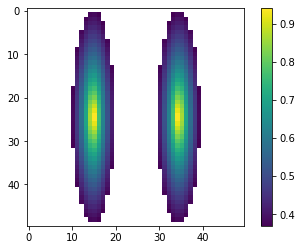

In [24]:
plt.imshow(potmesh_vtk_list[4][:,potmesh_vtk_list[4].shape[1]//2 - 1].T)
plt.colorbar()

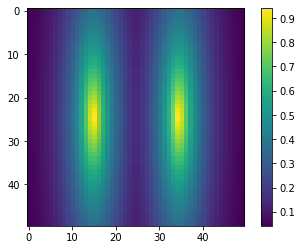

In [26]:
plt.imshow(tpot_cartlist[4][:,tpot_cartlist[4].shape[1]//2 - 1].T)
plt.colorbar()

In [27]:
"""
Use the l2norm of the difference between the analytical solution and the interpolated solution
as the measure of error related to the resolution of the grid.
"""

def calc_l2_norm(field):
    normconst = np.prod(field.shape)**(3/2)
    return np.sqrt(np.nansum(field**2))/normconst

l2s = np.zeros((len(potmesh_vtk_list),3))
for i in range(len(l2s)):
    for j in range(l2s.shape[1]):
        l2s[i,j] = calc_l2_norm(field = potmesh_vtk_list[i] - tpot_cartlist[i])


print(l2s[:,0])
print(l2s[:,1])
print(l2s[:,2])

[1.86397538e-08 4.51978916e-09 1.98288108e-09 1.10692948e-09
 7.37884369e-10]
[1.86397538e-08 4.51978916e-09 1.98288108e-09 1.10692948e-09
 7.37884369e-10]
[1.86397538e-08 4.51978916e-09 1.98288108e-09 1.10692948e-09
 7.37884369e-10]


In [28]:
ngridlist[:,0]

array([ 50, 100, 150, 200, 250])

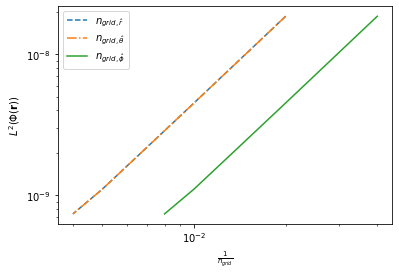

In [29]:
# make a list over the grid resolution

plt.figure()
plt.plot(1/ngridlist[:,0], l2s[:,0], '--',label = "$n_{grid, \\hat{r}}$")
plt.plot(1/ngridlist[:,1], l2s[:,1], '-.',label = "$n_{grid, \\hat{\\theta}}$")
plt.plot(1/ngridlist[:,2], l2s[:,2], '-',label = "$n_{grid, \\hat{\\phi}}$")
plt.xlabel("$\\frac{1}{n_{grid}}$")
plt.ylabel("$L^2(\\Phi(\\mathbf{r}))$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

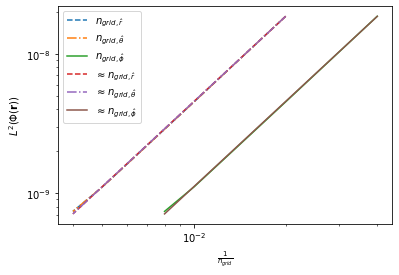

In [32]:
#%%writefile expofit.py
"""
Do exponential fit the gridscaling data compared with the l2 norm.
"""
def expofit(ngx, ngy, ngz, l2list):
    """
    Do exponential fit of the change in gridpoint res compared to l2 of the noise of a scalar field.
    Args:
    - ngx, array np.int32, array of grid res along x axis
    - ngy, array np.int32, array of grid res along y axis
    - ngz, array np.int32, array of grid res along z axis
    - l2list, array of np.float64, array of l2 norms for different resolutions
    Out:
    - None, plots the exponential fit.
    """
    import numpy as np
    ax, bx = np.polyfit(np.log(1/ngx), np.log(l2list[:,0]), 1, w=np.sqrt(l2list[:,0]))
    ay, by = np.polyfit(np.log(1/ngy), np.log(l2list[:,1]), 1, w=np.sqrt(l2list[:,1]))
    az, bz = np.polyfit(np.log(1/ngz), np.log(l2list[:,2]), 1, w=np.sqrt(l2list[:,2]))
    
    plt.figure()
    plt.plot(1/ngx, l2list[:,0], '--',label = "$n_{grid, \\hat{r}}$")
    plt.plot(1/ngy, l2list[:,1], '-.',label = "$n_{grid, \\hat{\\theta}}$")
    plt.plot(1/ngz, l2list[:,2], '-',label = "$n_{grid, \\hat{\\phi}}$")
    plt.plot(1/ngx, np.exp(ax*np.log(1/ngx) + bx), '--',label = "$\\approx n_{grid, \\hat{r}}$")
    plt.plot(1/ngy, np.exp(ay*np.log(1/ngy) + by), '-.',label = "$\\approx n_{grid, \\hat{\\theta}}$")
    plt.plot(1/ngz, np.exp(az*np.log(1/ngz) + bz), '-',label = "$\\approx n_{grid, \\hat{\\phi}}$")
    plt.xlabel("$\\frac{1}{n_{grid}}$")
    plt.ylabel("$L^2(\\Phi(\\mathbf{r}))$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()
    
expofit(ngx = ngridlist[:,0], ngy = ngridlist[:,1], ngz = ngridlist[:,2], l2list = l2s)